# Import Packages

In [11]:
from utils import draw_results

import mne
from scipy.stats import ttest_1samp
from mne.stats import fdr_correction
from scipy.stats import trim_mean
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib
from pylab import mpl
import numpy as np
import dill

In [12]:
plt.rcParams['font.family']=['Arial','serif', 'Times New Roman']
plt.style.use('default')
mpl.rcParams["axes.unicode_minus"] = False
%config InlineBackend.figure_format = 'svg'

In [ ]:
erp_res = np.zeros((24, 6, 61, 501))

trim = lambda x: trim_mean(x, 0.2, axis=0)

file_path = "../data/EEG/Subject_"

for subject in range(1, 25):

    file = file_path + str(subject) + '_epo.fif'        
    epochs = mne.read_epochs(file, preload=True)
    subject -= 1

    epochs = epochs.crop(tmin=0.0, tmax=1.0)

    events_dict = { }

    for sym in ['pic', 'icon', 'text']: # 3 symbol types
        for size in ['s', 'b']: # 2 conceptual sizes
            events_dict[sym+str(size)] = []

    for id in epochs.event_id:
        # id : ab-cd-e-f-ghi
        # a : symbol type of first stimulus (1 for picture, 2 for icon, 3 for text)
        # b : concept of first stimulus (1-6 for scooter-train)
        # c : symbol type of second stimulus (1 for picture, 2 for icon, 3 for text)
        # d : concept of second stimulus (1-6 for scooter-train)

        small = ['1', '2', '3']
        big = ['4', '5', '6']   
        if id[0] == '1' and id[1] in small:
            events_dict['pics'].append(id)
        if id[0] == '1' and id[1] in big:
            events_dict['picb'].append(id)
        
        if id[0] == '2' and id[1] in small:
            events_dict['icons'].append(id)
        if id[0] == '2' and id[1] in big:
            events_dict['iconb'].append(id)
        
        if id[0] == '3' and id[1] in small:
            events_dict['texts'].append(id)
        if id[0] == '3' and id[1] in big:
            events_dict['textb'].append(id)

    erp_res[subject, 0] = epochs[events_dict['pics']].average(method=trim).get_data()
    erp_res[subject, 1] = epochs[events_dict['picb']].average(method=trim).get_data()
    erp_res[subject, 2] = epochs[events_dict['icons']].average(method=trim).get_data()
    erp_res[subject, 3] = epochs[events_dict['iconb']].average(method=trim).get_data()
    erp_res[subject, 4] = epochs[events_dict['texts']].average(method=trim).get_data()
    erp_res[subject, 5] = epochs[events_dict['textb']].average(method=trim).get_data(); # [61, 501]

# paired t-test function

In [14]:
def paired_ttest(erp_1, erp_2, chance=0.0):

    # erp [24, 61, 501]
    
    p_vals = np.zeros((61, 501))
    corr_p = np.zeros((61, 501))
    
    for ch in range(61):
        ch_data_1 = erp_1[:,ch,:]
        ch_data_2 = erp_2[:,ch,:]
        
        _, p_vals[ch] = ttest_1samp( ch_data_1-ch_data_2, chance, axis=0 )
        
    # FDR Correction
    for t in range(501):
        reject_fdr, pval_corr = fdr_correction(p_vals[:, t], alpha=0.05, method="indep") 
        corr_p[:, t] = pval_corr

    return corr_p    

# paired ttest for real-world sizes in picture

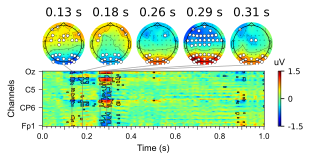

In [29]:
ind0 = 0
ind1 = 1

p_corr = paired_ttest(erp_res[:, ind0], erp_res[:, ind1])

erp_diff_avg = (np.mean(erp_res[:, ind0], axis=0) - np.mean(erp_res[:, ind1], axis=0) ) * 1e6 # [24, 9, 61, 501]
fake_evk = mne.EvokedArray( erp_diff_avg, epochs.info, tmin=0 )
fake_evk.nave = None
fake_evk.set_montage(epochs.get_montage())

draw_results.plot_topomap_joint(fake_evk, p_corr<0.05, figsize=(5, 2), units='uV',
                           vmin=-1.5, vmax=1.5, cmap='jet', minor_tick=0.02,
                           time_points=[ 0.133, 0.18, 0.26, 0.29, 0.31 ],
                           cbar_ticks=[-1.5, 0, 1.5], vmask_delete=4)

In [30]:
erp = np.sum(p_corr < 0.05, axis=0)

with open('./ttest_p_num_picture.pkl', 'wb') as f:
    dill.dump(erp, f)

# paired ttest for real-world sizes in icon

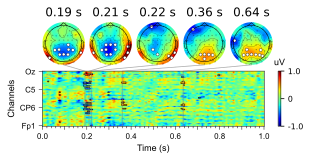

In [31]:
ind0 = 2
ind1 = 3

p_corr = paired_ttest(erp_res[:, ind0], erp_res[:, ind1])

erp_diff_avg = (np.mean(erp_res[:, ind0], axis=0) - np.mean(erp_res[:, ind1], axis=0) ) * 1e6 # [24, 9, 61, 501]
fake_evk = mne.EvokedArray( erp_diff_avg, epochs.info, tmin=0 )
fake_evk.nave = None
fake_evk.set_montage(epochs.get_montage())

draw_results.plot_topomap_joint(fake_evk, p_corr<0.05, figsize=(5, 2), units='uV',
                           vmin=-1.0, vmax=1.0, cmap='jet', minor_tick=0.02,
                           time_points=[ 0.192, 0.21, 0.22, 0.36, 0.635 ],
                           cbar_ticks=[-1.0, 0, 1.0], vmask_delete=3)

In [32]:
erp = np.sum(p_corr < 0.05, axis=0)

with open('./ttest_p_num_icon.pkl', 'wb') as f:
    dill.dump(erp, f)

# paired ttest for real-world sizes in text

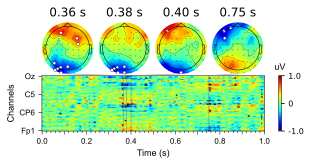

In [33]:
ind0 = 4
ind1 = 5

p_corr = paired_ttest(erp_res[:, ind0], erp_res[:, ind1])

erp_diff_avg = (np.mean(erp_res[:, ind0], axis=0) - np.mean(erp_res[:, ind1], axis=0) ) * 1e6 # [24, 9, 61, 501]
fake_evk = mne.EvokedArray( erp_diff_avg, epochs.info, tmin=0 )
fake_evk.nave = None
fake_evk.set_montage(epochs.get_montage())

draw_results.plot_topomap_joint(fake_evk, p_corr<0.05, figsize=(5, 2), units='uV',
                           vmin=-1.0, vmax=1.0, cmap='jet', minor_tick=0.02,
                           time_points=[ 0.365, 0.38, 0.40, 0.75 ],
                           cbar_ticks=[-1.0, 0, 1.0])

In [34]:
erp = np.sum(p_corr < 0.05, axis=0)

with open('./ttest_p_num_text.pkl', 'wb') as f:
    dill.dump(erp, f)